In [17]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_absolute_error,
    mean_squared_error, r2_score
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE

import shap
import boto3
from botocore.exceptions import ClientError

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### Cell 1: Library Imports & Reproducibility Setup

In this cell, we import all the required Python libraries for data processing, visualization, machine learning, explainability (SHAP), and AWS integration. These libraries will be used throughout the project for building, evaluating, and interpreting the models.

We also fix the `RANDOM_STATE` to ensure that our results are reproducible, meaning that the same train–test split, SMOTE sampling, and model training will produce consistent results each time the notebook is executed.


In [18]:
# Configuration and S3 setup

CONFIG = {
    "AWS_REGION": "us-east-1",
    "S3_BUCKET": "mlc-group7-project",                 
    "S3_KEY": "datasets/car_insurance_claim.csv",      
    "LOCAL_DATA_PATH": "car_insurance_claim.csv",      # local CSV file path
}

# Initialize S3 client
s3 = boto3.client("s3", region_name=CONFIG["AWS_REGION"])


### Cell 2: AWS S3 Configuration and Client Setup

In this cell, we define the main AWS configuration such as the region, S3 bucket name, S3 file path, and the local CSV file path. This configuration helps us manage both local and cloud-based data access in a structured way.

We also initialize the AWS S3 client using the boto3 library. This client will be used in later cells to create the bucket, upload the dataset, list bucket contents, and load data from S3.


In [20]:
# Create the bucket if it does not exist

bucket_name = CONFIG["S3_BUCKET"]
region = CONFIG["AWS_REGION"]

try:
    if region == "us-east-1":
        s3.create_bucket(Bucket=bucket_name)
    else:
        s3.create_bucket(
            Bucket=bucket_name,
            CreateBucketConfiguration={"LocationConstraint": region},
        )
    print(f"Bucket created successfully: {bucket_name}")
except Exception as e:
    print("Bucket may already exist or you may lack permissions.")
    print("Error:", e)

# Verify by listing all buckets in the account
response = s3.list_buckets()
print("\nAll buckets in your account:")
for b in response.get("Buckets", []):
    print(f" - {b['Name']} (Created on: {b['CreationDate']})")

# ============================================================
# Upload dataset to S3 and verify
# ============================================================

file_path = CONFIG["LOCAL_DATA_PATH"]
s3_key = CONFIG["S3_KEY"]

try:
    s3.upload_file(file_path, bucket_name, s3_key)
    print(f"\nFile uploaded successfully to s3://{bucket_name}/{s3_key}")
except Exception as e:
    print("\nUpload failed. Check permissions or file path.")
    print("Error:", e)

# Verify contents in S3 under the datasets/ prefix
try:
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix="datasets/")
    if "Contents" in response:
        print(f"\nFiles in s3://{bucket_name}/datasets/")
        for obj in response["Contents"]:
            print(f" - {obj['Key']}  ({obj['Size']} bytes)")
    else:
        print("No files found in S3 folder.")
except Exception as e:
    print("Error listing S3 contents:", e)


Bucket created successfully: mlc-group7-project

All buckets in your account:
 - ankitasaha-assignment7-data (Created on: 2025-11-12 23:47:02+00:00)
 - custom-labels-console-us-east-1-f7ac886b54 (Created on: 2025-11-12 23:41:48+00:00)
 - ml-data-ankitasaha-ankitas6 (Created on: 2025-10-04 00:14:08+00:00)
 - mlc-group7-project (Created on: 2025-11-29 22:25:11+00:00)

File uploaded successfully to s3://mlc-group7-project/datasets/car_insurance_claim.csv

Files in s3://mlc-group7-project/datasets/
 - datasets/car_insurance_claim.csv  (1580749 bytes)


### Cell 3: Creating the S3 Bucket and Uploading the Dataset

In this cell, we attempt to create an S3 bucket using the bucket name defined in the configuration. If the bucket already exists or if permissions are limited, an appropriate message is displayed.

Next, we upload the local dataset file to the S3 bucket under the specified folder path. After uploading, we list all available files inside the datasets folder in the bucket to verify that the upload was successful.

This step connects our local project to cloud storage and prepares the data for cloud-based access.


In [21]:
# Load dataset for EDA

# We first try to load from S3 using the s3:// path.
# If that fails (for example due to missing permissions or missing s3fs),
# we fall back to loading from the local CSV file.

s3_path = f"s3://{CONFIG['S3_BUCKET']}/{CONFIG['S3_KEY']}"

data_df = None

try:
    print(f"Attempting to load dataset from {s3_path} ...")
    data_df = pd.read_csv(s3_path)
    print("Dataset loaded successfully from S3.")
except Exception as e:
    print("Could not load from S3, falling back to local file.")
    print("Error:", e)
    print(f"Loading from local path: {CONFIG['LOCAL_DATA_PATH']}")
    data_df = pd.read_csv(CONFIG["LOCAL_DATA_PATH"])
    print("Dataset loaded successfully from local file.")

print("Shape:", data_df.shape)
data_df.head()


Attempting to load dataset from s3://mlc-group7-project/datasets/car_insurance_claim.csv ...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:298: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Dataset loaded successfully from S3.
Shape: (10302, 27)


,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


### Cell 4: Loading the Dataset from S3 or Local System

In this cell, we attempt to load the dataset directly from the S3 bucket using the s3 path. If the S3 loading fails due to missing permissions or missing dependencies, the code automatically falls back to loading the CSV file from the local system.

This dual-loading approach ensures that the notebook can run reliably in both cloud-enabled and local environments without breaking the workflow.

Once loaded, we display the shape of the dataset and preview the first few rows to confirm successful data loading.


In [22]:
#  EDA – structure, missingness, and type corrections

data_df.info()
print("\nMissing values per column:\n", data_df.isna().sum())

# Convert currency-like columns to numeric if necessary
money_cols = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM", "CLM_AMT"]
for col in money_cols:
    if col in data_df.columns and data_df[col].dtype == "O":
        data_df[col] = (
            data_df[col]
            .replace("[^0-9.]", "", regex=True)
            .replace("", np.nan)
            .astype(float)
        )

# Fix CAR_AGE unrealistic values: clip between 0 and 30 years
if "CAR_AGE" in data_df.columns:
    car_age = data_df["CAR_AGE"]
    median_age = car_age[(car_age >= 0) & (car_age <= 30)].median()
    data_df["CAR_AGE"] = car_age.clip(lower=0, upper=30).fillna(median_age)

# Basic distributions for a few important numeric columns
numeric_preview = ["AGE", "INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM", "CLM_AMT"]
numeric_preview = [c for c in numeric_preview if c in data_df.columns]

data_df[numeric_preview].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   BIRTH       10302 non-null  object 
 3   AGE         10295 non-null  float64
 4   HOMEKIDS    10302 non-null  int64  
 5   YOJ         9754 non-null   float64
 6   INCOME      9732 non-null   object 
 7   PARENT1     10302 non-null  object 
 8   HOME_VAL    9727 non-null   object 
 9   MSTATUS     10302 non-null  object 
 10  GENDER      10302 non-null  object 
 11  EDUCATION   10302 non-null  object 
 12  OCCUPATION  9637 non-null   object 
 13  TRAVTIME    10302 non-null  int64  
 14  CAR_USE     10302 non-null  object 
 15  BLUEBOOK    10302 non-null  object 
 16  TIF         10302 non-null  int64  
 17  CAR_TYPE    10302 non-null  object 
 18  RED_CAR     10302 non-null  object 
 19  OLDCLAIM    10302 non-nul

,AGE,INCOME,HOME_VAL,BLUEBOOK,OLDCLAIM,CLM_AMT
count,10295.000000,9732.000000,9727.000000,10302.000000,10302.000000,10302.000000
mean,44.837397,61572.073263,154523.018608,15659.923316,4033.977868,1511.266453
std,8.606445,47457.202749,129188.439405,8428.765264,8733.143119,4725.249896
min,16.000000,0.000000,0.000000,1500.000000,0.000000,0.000000
25%,39.000000,27584.000000,0.000000,9200.000000,0.000000,0.000000
50%,45.000000,53529.000000,160661.000000,14400.000000,0.000000,0.000000
75%,51.000000,86166.000000,238256.000000,20890.000000,4647.500000,1144.750000
max,81.000000,367030.000000,885282.000000,69740.000000,57037.000000,123247.000000


### Cell 5: Dataset Structure, Missing Values, and Basic Statistics

In this cell, we inspect the structure of the dataset to understand the number of rows, columns, data types, and missing values. The dataset contains 10,302 records and 27 columns, including both numerical and categorical features related to drivers, vehicles, and insurance history.

We observe that several important numerical columns such as AGE, YOJ, INCOME, HOME_VAL, and CAR_AGE contain missing values. These missing values will later be handled using appropriate imputation strategies during preprocessing.

Some columns such as INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM, and CLM_AMT initially appear as object types because they contain currency-like formatting. These are converted into proper numeric values for modeling.

The summary statistics show that:
- The average customer age is around 45 years.
- The average annual income is about 61,500.
- The average vehicle value (BLUEBOOK) is about 15,660.
- The average historical claim amount (OLDCLAIM) is about 4,034.
- The distribution of claim amount (CLM_AMT) is highly skewed, with many zero values and a few very large claims.

These observations confirm that the dataset represents realistic insurance data with missing values, skewed monetary variables, and a mix of demographic, behavioral, and vehicle-related features.


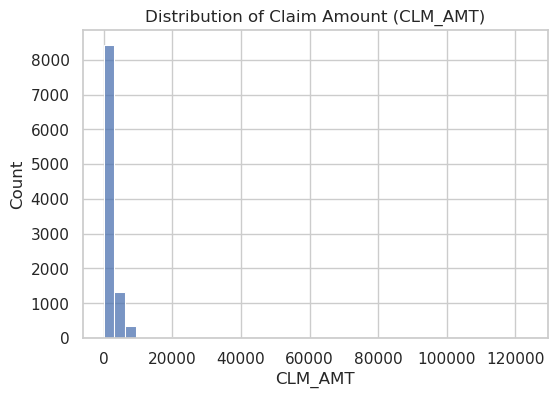

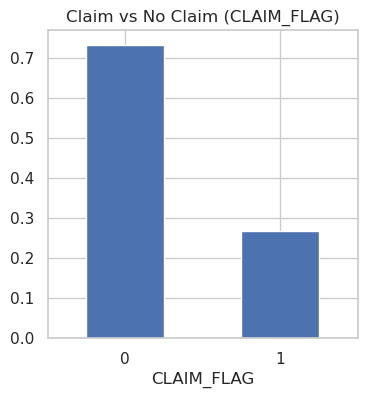

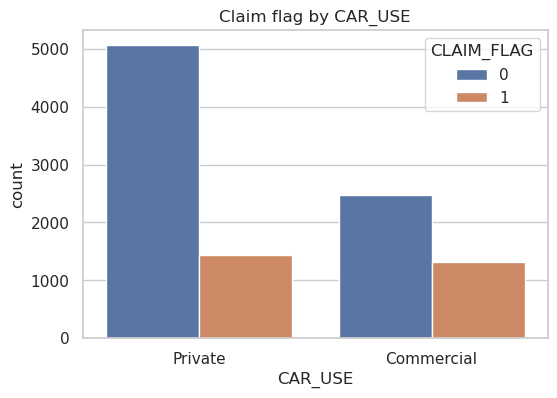

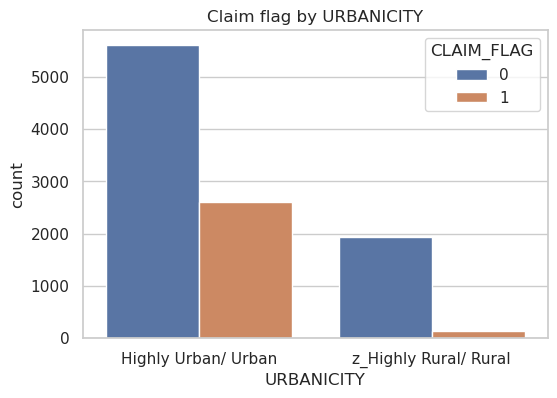

In [23]:
# Visual EDA – histograms and countplots

sns.set(style="whitegrid")

# 1) Histogram of claim amount (CLM_AMT)
plt.figure(figsize=(6,4))
sns.histplot(data_df["CLM_AMT"], bins=40)
plt.title("Distribution of Claim Amount (CLM_AMT)")
plt.show()

# 2) Claim flag proportions
plt.figure(figsize=(4,4))
data_df["CLAIM_FLAG"].value_counts(normalize=True).plot(kind="bar")
plt.title("Claim vs No Claim (CLAIM_FLAG)")
plt.xticks(rotation=0)
plt.show()

# 3) Claims by CAR_USE
if "CAR_USE" in data_df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=data_df, x="CAR_USE", hue="CLAIM_FLAG")
    plt.title("Claim flag by CAR_USE")
    plt.show()

# 4) Claims by URBANICITY
if "URBANICITY" in data_df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=data_df, x="URBANICITY", hue="CLAIM_FLAG")
    plt.title("Claim flag by URBANICITY")
    plt.show()


### Cell 6: Visual Exploratory Data Analysis

In this cell, we visualize key patterns in the dataset to better understand the behavior of claims and their relationship with important features.

The histogram of claim amount (CLM_AMT) shows that most claims are very small or zero, while a few claims are extremely large. This means the claim amount distribution is highly right-skewed, which is common in real insurance data and motivates the need for outlier handling during severity modeling.

The bar chart of CLAIM_FLAG shows that a much larger proportion of customers do not file any claims compared to those who do. This confirms that the dataset is clearly imbalanced, which justifies the use of SMOTE later in the modeling pipeline.

The plot of CLAIM_FLAG by CAR_USE shows that commercial vehicles have a relatively higher proportion of claim cases compared to private vehicles. This suggests that commercial vehicle usage is associated with higher risk, likely due to increased road exposure.

The plot of CLAIM_FLAG by URBANICITY shows that customers living in highly urban or urban areas have a much higher number of claims compared to customers in rural areas. This indicates that location plays an important role in claim risk, likely due to factors such as traffic density and congestion.

Overall, these visualizations provide early evidence that claim risk is influenced by usage type, geographic environment, and the highly imbalanced nature of insurance claims.


In [24]:
# Feature engineering: cleaned claim value & stratification bins

# Cleaned claim amount 
# Remove extreme top 5% outliers to make severity model more stable
q95 = data_df["CLM_AMT"].quantile(0.95)
data_df["new_claim_value"] = data_df["CLM_AMT"].clip(upper=q95)

# Sanity check: whenever claim amount > 0, CLAIM_FLAG should be 1
mask_inconsistent = (data_df["new_claim_value"] > 0) & (data_df["CLAIM_FLAG"] == 0)
print("Inconsistent records (should be 0):", mask_inconsistent.sum())
# (optional) drop inconsistent rows
data_df = data_df[~mask_inconsistent].reset_index(drop=True)

# Create bins for new_claim_value
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, np.inf]
labels = np.arange(1, len(bins))  # 1..9
data_df["claim_value_cat"] = pd.cut(
    data_df["new_claim_value"], bins=bins, labels=labels, include_lowest=True
)

data_df[["new_claim_value", "claim_value_cat"]].head()


Inconsistent records (should be 0): 0


,new_claim_value,claim_value_cat
0,0.0,1
1,0.0,1
2,0.0,1
3,0.0,1
4,0.0,1


### Cell 7: Claim Value Cleaning and Feature Engineering

In this cell, we perform feature engineering for the claim severity task by creating a stabilized version of the claim amount called new_claim_value. Extreme claim values above the 95th percentile are capped to reduce the impact of outliers and make the severity model more stable.

We then perform a consistency check to ensure that whenever new_claim_value is greater than zero, the corresponding CLAIM_FLAG is equal to 1. The output shows that there are zero inconsistent records, which confirms that the claim indicators and claim amounts are aligned correctly.

Next, we create a categorical feature called claim_value_cat by binning the new_claim_value into multiple ranges. These bins will later be used to ensure proper stratification during the train–test split so that both low-cost and high-cost claims are well represented in both sets.

The preview of new_claim_value and claim_value_cat confirms that zero-claim records are correctly placed into the lowest category.


In [25]:
# Stratified train/test split using claim value categories

# Rows with no claim have new_claim_value == 0 and claim_value_cat == 1
# For stratification we use CLAIM_FLAG primarily, but within positive claims the bins ensure cost distribution is represented.

# Build a stratification label combining CLAIM_FLAG and claim_value_cat
strata = data_df["CLAIM_FLAG"].astype(str) + "_" + data_df["claim_value_cat"].astype(str)

splitter = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDOM_STATE
)

for train_idx, test_idx in splitter.split(data_df, strata):
    train_df = data_df.iloc[train_idx].reset_index(drop=True)
    test_df = data_df.iloc[test_idx].reset_index(drop=True)

print("Train shape:", train_df.shape, " Test shape:", test_df.shape)

train_df["CLAIM_FLAG"].value_counts(normalize=True), test_df["CLAIM_FLAG"].value_counts(normalize=True)


Train shape: (8241, 29)  Test shape: (2061, 29)


(CLAIM_FLAG
 0    0.733406
 1    0.266594
 Name: proportion, dtype: float64,
 CLAIM_FLAG
 0    0.733624
 1    0.266376
 Name: proportion, dtype: float64)

### Cell 8: Stratified Train–Test Split

In this cell, we split the dataset into training and testing sets using stratified sampling. The stratification is based on a combination of CLAIM_FLAG and the engineered claim value category, which helps preserve both claim occurrence and claim cost distribution across the two sets.

The output shows that the training set contains 8,241 records and the test set contains 2,061 records. The proportion of CLAIM_FLAG is nearly identical in both datasets, with about 73 percent non-claim cases and 27 percent claim cases.

This confirms that the train and test datasets are well-balanced with respect to the target variable. As a result, the test set provides a fair and realistic evaluation of the model on unseen data.


In [26]:
# Define feature lists and preprocessing pipelines

TARGET_CLS = "CLAIM_FLAG"
TARGET_REG = "new_claim_value"

drop_cols = ["ID", "BIRTH"]  # IDs / leakiness
for c in drop_cols:
    if c in train_df.columns:
        train_df = train_df.drop(columns=[c])
        test_df = test_df.drop(columns=[c])

# Numeric and categorical features 
numeric_features = [
    "AGE", "HOMEKIDS", "YOJ", "INCOME", "HOME_VAL",
    "TRAVTIME", "BLUEBOOK", "TIF", "OLDCLAIM",
    "CLM_FREQ", "MVR_PTS", "CAR_AGE"
]
numeric_features = [c for c in numeric_features if c in train_df.columns]

categorical_features = [
    "PARENT1", "MSTATUS", "GENDER", "EDUCATION",
    "OCCUPATION", "CAR_USE", "CAR_TYPE",
    "RED_CAR", "REVOKED", "URBANICITY"
]
categorical_features = [c for c in categorical_features if c in train_df.columns]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Numeric features: ['AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE']
Categorical features: ['PARENT1', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY']


### Cell 9: Feature Selection and Preprocessing Setup

In this cell, we define the target variables for the classification and regression tasks and remove any identifier or leakage columns that should not be used for modeling.

We then separate the input features into numerical and categorical groups. The numerical features include variables such as age, income, vehicle value, travel time, past claims, driving record points, and car age. These features capture continuous risk-related information.

The categorical features include demographic, behavioral, and vehicle-related attributes such as marital status, gender, education, occupation, car usage, car type, revoked license status, and urbanicity. These features represent discrete characteristics of the policyholder and the vehicle.

Next, we define preprocessing pipelines for both feature types. Numerical features are imputed using the median and scaled, while categorical features are imputed using the most frequent value and encoded using one-hot encoding. Finally, a column transformer is created to apply the correct transformations to each feature group in a single step.


In [27]:
# Build X/y for classification and apply SMOTE on train only

X_train_cls = train_df[numeric_features + categorical_features]
y_train_cls = train_df[TARGET_CLS].astype(int)

X_test_cls = test_df[numeric_features + categorical_features]
y_test_cls = test_df[TARGET_CLS].astype(int)

# Fit preprocessing on TRAIN only
X_train_pre = preprocessor.fit_transform(X_train_cls)
X_test_pre = preprocessor.transform(X_test_cls)

print("Preprocessed shapes:", X_train_pre.shape, X_test_pre.shape)

# SMOTE on preprocessed train features
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pre, y_train_cls)

print("Class balance before SMOTE:", y_train_cls.value_counts())
print("Class balance after SMOTE:", y_train_smote.value_counts())


Preprocessed shapes: (8241, 45) (2061, 45)
Class balance before SMOTE: CLAIM_FLAG
0    6044
1    2197
Name: count, dtype: int64
Class balance after SMOTE: CLAIM_FLAG
0    6044
1    6044
Name: count, dtype: int64


### Cell 10: Data Preprocessing and Class Imbalance Handling with SMOTE

In this cell, we first apply the preprocessing pipeline to the training and test datasets. After preprocessing and one-hot encoding, the number of features increases to 45. This shows that the original categorical variables have been successfully converted into numerical form for modeling.

The class distribution before applying SMOTE shows that the dataset is imbalanced, with 6,044 non-claim cases and 2,197 claim cases in the training set. This imbalance can cause the model to favor the majority class if left untreated.

After applying SMOTE to the preprocessed training data, the class distribution becomes perfectly balanced, with 6,044 records in both the claim and no-claim classes. This ensures that the classifier gives equal importance to both outcomes during training and improves its ability to learn patterns associated with claim cases.


In [28]:
# Train baseline RandomForest classifier

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

clf.fit(X_train_smote, y_train_smote)

y_pred = clf.predict(X_test_pre)
y_proba = clf.predict_proba(X_test_pre)[:, 1]

print("Accuracy:", accuracy_score(y_test_cls, y_pred))
print("Precision:", precision_score(y_test_cls, y_pred))
print("Recall:", recall_score(y_test_cls, y_pred))
print("F1:", f1_score(y_test_cls, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_cls, y_proba))

conf_mat = confusion_matrix(y_test_cls, y_pred)
conf_mat


Accuracy: 0.774866569626395
Precision: 0.5986078886310905
Recall: 0.46994535519125685
F1: 0.5265306122448979
ROC-AUC: 0.8072397143435394


array([[1339,  173],
       [ 291,  258]])

### Cell 11: Baseline Random Forest Classifier Performance

In this cell, we train the initial Random Forest classifier using the SMOTE-balanced training data and evaluate its performance on the untouched test set.

The model achieves an accuracy of about 0.775, which means that approximately 77.5 percent of the test records are classified correctly. However, accuracy alone is not sufficient for evaluating insurance claim prediction because the dataset is imbalanced.

The precision value of about 0.599 indicates that when the model predicts a claim, around 60 percent of those predictions are correct. The recall value of about 0.470 shows that the model is able to correctly identify about 47 percent of all actual claim cases. The F1 score of about 0.527 reflects a balanced trade-off between precision and recall.

The ROC-AUC score is about 0.807, which indicates that the model has a strong ability to separate claim and no-claim cases across different probability thresholds. This confirms that the model has learned meaningful risk patterns rather than making random predictions.

The confusion matrix shows that 1,339 no-claim cases and 258 claim cases are correctly classified. At the same time, 173 no-claim cases are incorrectly predicted as claims, and 291 claim cases are incorrectly predicted as no-claims. From a business perspective, the false negatives are especially important because they represent risky customers that the model fails to detect.

Overall, this baseline Random Forest model provides a solid starting point, and further improvements are made in later steps using SHAP-based feature selection.


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train_smote, y_train_smote)

y_proba_lr = log_reg.predict_proba(X_test_pre)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

print("=== Baseline vs RandomForest (before feature reduction) ===")

print("\nLogistic Regression baseline:")
print(classification_report(y_test_cls, y_pred_lr))
roc_auc_lr = roc_auc_score(y_test_cls, y_proba_lr)
print(f"ROC-AUC (LogReg): {roc_auc_lr:.3f}")

print("\nRandomForest (full features):")
print(classification_report(y_test_cls, y_pred))
roc_auc_rf = roc_auc_score(y_test_cls, y_proba)
print(f"ROC-AUC (RandomForest): {roc_auc_rf:.3f}")


=== Baseline vs RandomForest (before feature reduction) ===

Logistic Regression baseline:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1512
           1       0.48      0.75      0.58       549

    accuracy                           0.71      2061
   macro avg       0.68      0.72      0.68      2061
weighted avg       0.78      0.71      0.73      2061

ROC-AUC (LogReg): 0.806

RandomForest (full features):
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1512
           1       0.60      0.47      0.53       549

    accuracy                           0.77      2061
   macro avg       0.71      0.68      0.69      2061
weighted avg       0.76      0.77      0.77      2061

ROC-AUC (RandomForest): 0.807


### Cell 12: Baseline Comparison Using Logistic Regression

In this cell, we compare a simple Logistic Regression baseline model with the Random Forest classifier trained using all features. This comparison helps us understand whether the added complexity of Random Forest actually improves performance over a linear model.

For the Logistic Regression model, the accuracy is about 0.71. The recall for the claim class is about 0.75, which means the model is able to identify a large portion of actual claim cases. However, the precision for the claim class is only about 0.48, which means that many of the predicted claims are actually false alarms. The ROC-AUC score is about 0.806, indicating good overall discrimination ability.

For the Random Forest model using all features, the accuracy improves to about 0.77. The precision for the claim class increases to about 0.60, meaning the model is more reliable when it predicts a claim. However, the recall drops to about 0.47, meaning fewer actual claim cases are detected compared to Logistic Regression. The ROC-AUC score is about 0.807, which is very similar to that of Logistic Regression.

This comparison shows a clear trade-off between the two models. Logistic Regression achieves higher recall for claim cases but at the cost of many false positives, while Random Forest achieves better precision and higher overall accuracy but lower recall. Since insurance modeling often prefers a balance between identifying risky customers and avoiding too many false alarms, we proceed with Random Forest and later refine it using SHAP-based feature selection.


### SHAP Analysis – Claim Frequency Model (Will a claim occur?)

Using 800 samples out of 2061 for SHAP.


100%|===================| 1599/1600 [07:43<00:00]        

shap_vals shape: (800, 45)
X_test_sample shape: (800, 45)


/tmp/ipykernel_8090/2068518009.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


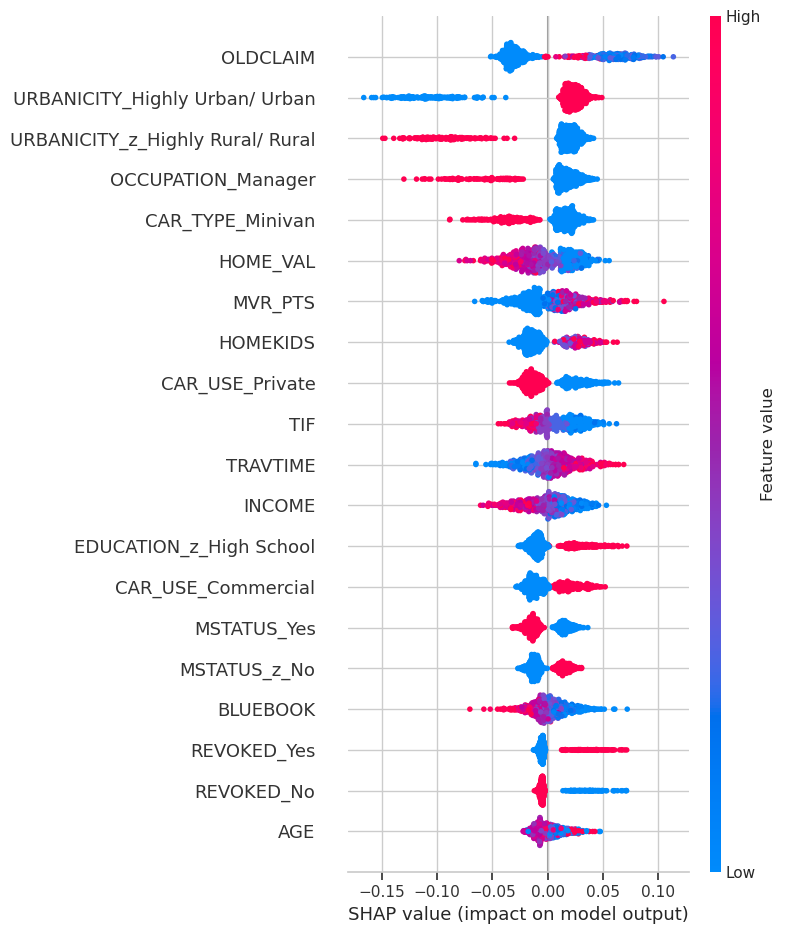

,feature,mean_abs_shap
0,OLDCLAIM,0.041229
1,URBANICITY_Highly Urban/ Urban,0.039378
2,URBANICITY_z_Highly Rural/ Rural,0.033915
3,OCCUPATION_Manager,0.023866
4,CAR_TYPE_Minivan,0.022272
5,HOME_VAL,0.020577
6,MVR_PTS,0.019586
7,HOMEKIDS,0.019025
8,CAR_USE_Private,0.018444
9,TIF,0.017618


Number of low-importance features to drop: 12


In [31]:
# Unified SHAP cell: compute SHAP, plot, and build importance table 
shap.initjs()

# 1) Build feature name list after preprocessing
ohe = preprocessor.named_transformers_["cat"]["encoder"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names

# 2) Sample from the preprocessed TEST data
rng = np.random.default_rng(RANDOM_STATE)

n_test = X_test_pre.shape[0]
max_samples = 800         
sample_size = min(max_samples, n_test)

sample_idx = rng.choice(n_test, size=sample_size, replace=False)
X_test_sample = X_test_pre[sample_idx]

print(f"Using {sample_size} samples out of {n_test} for SHAP.")

# 3) Background data from TRAIN
n_train = X_train_pre.shape[0]
bg_size = min(200, n_train)
bg_idx = rng.choice(n_train, size=bg_size, replace=False)
background = X_train_pre[bg_idx]

# 4) Build explainer and compute SHAP values on the SAME matrix we will plot
explainer_cls = shap.TreeExplainer(clf, data=background)

shap_values_raw = explainer_cls.shap_values(
    X_test_sample,
    check_additivity=False  
)

# 5) Normalize SHAP output shape:
if isinstance(shap_values_raw, list):
    shap_vals = shap_values_raw[1]
elif isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 3:
    shap_vals = shap_values_raw[:, :, 1]   # class 1 only
else:
    shap_vals = shap_values_raw

print("shap_vals shape:", shap_vals.shape)
print("X_test_sample shape:", X_test_sample.shape)

# Sanity checks
assert shap_vals.shape[0] == X_test_sample.shape[0], "Row count mismatch!"
assert shap_vals.shape[1] == X_test_sample.shape[1], "Feature count mismatch!"
assert shap_vals.shape[1] == len(all_feature_names), "Feature name length mismatch!"

# 6) SHAP summary plot for the classifier (class 1 = claim)
shap.summary_plot(
    shap_vals,
    X_test_sample,
    feature_names=all_feature_names
)

# 7) Global SHAP importance (mean |SHAP| per feature)

mean_abs_shap = np.abs(shap_vals).mean(axis=0) 

shap_importance = (
    pd.DataFrame(
        {"feature": all_feature_names, "mean_abs_shap": mean_abs_shap}
    )
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

display(shap_importance.head(20))

# 8) Threshold for dropping weak features
threshold = shap_importance["mean_abs_shap"].median() * 0.3

low_importance_features = shap_importance.loc[
    shap_importance["mean_abs_shap"] < threshold, "feature"
].tolist()

print("Number of low-importance features to drop:", len(low_importance_features))



### Cell 13: SHAP Analysis for Claim Frequency Model

In this cell, we use SHAP to explain which features influence the claim prediction model the most. We compute SHAP values using 800 randomly selected test samples.

The SHAP summary plot shows that OLDCLAIM, URBANICITY, OCCUPATION, CAR_TYPE, HOME_VAL, and MVR_PTS are among the strongest drivers of claim risk. This means that past claims, location, job type, vehicle type, property value, and driving record play a major role in determining whether a customer files a claim.

We also compute the average absolute SHAP value for each feature and rank them by importance. Based on a threshold, 12 low-impact features are identified and prepared for removal in the next step to simplify the model.


In [32]:
# Re-train RandomForest after dropping low-importance columns

# Build a mask to keep only important columns in the preprocessed matrices
keep_mask = ~np.isin(all_feature_names, low_importance_features)

X_train_smote_reduced = X_train_smote[:, keep_mask]
X_test_pre_reduced = X_test_pre[:, keep_mask]
reduced_feature_names = [f for f, keep in zip(all_feature_names, keep_mask) if keep]

clf_reduced = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

clf_reduced.fit(X_train_smote_reduced, y_train_smote)

y_pred_reduced = clf_reduced.predict(X_test_pre_reduced)
y_proba_reduced = clf_reduced.predict_proba(X_test_pre_reduced)[:, 1]

print("Reduced model performance")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_reduced))
print("Precision:", precision_score(y_test_cls, y_pred_reduced))
print("Recall:", recall_score(y_test_cls, y_pred_reduced))
print("F1:", f1_score(y_test_cls, y_pred_reduced))
print("ROC-AUC:", roc_auc_score(y_test_cls, y_proba_reduced))


Reduced model performance
Accuracy: 0.779718583212033
Precision: 0.6072234762979684
Recall: 0.4899817850637523
F1: 0.5423387096774194
ROC-AUC: 0.8093852699954702


### Cell 14: Performance After SHAP-Based Feature Reduction

After removing 12 low-importance features identified using SHAP, we retrain the Random Forest classifier using the reduced feature set.

The reduced model achieves an accuracy of about 0.78, precision of about 0.61, recall of about 0.49, and an F1 score of about 0.54. The ROC-AUC improves slightly to about 0.81.

This shows that removing weak features does not hurt performance and even slightly improves the model’s ability to separate claim and no-claim cases, while making the model simpler and more interpretable.


=== Final Classifier (RandomForest with SHAP-based feature reduction) ===

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1512
           1       0.61      0.49      0.54       549

    accuracy                           0.78      2061
   macro avg       0.72      0.69      0.70      2061
weighted avg       0.77      0.78      0.77      2061



<Figure size 400x400 with 0 Axes>

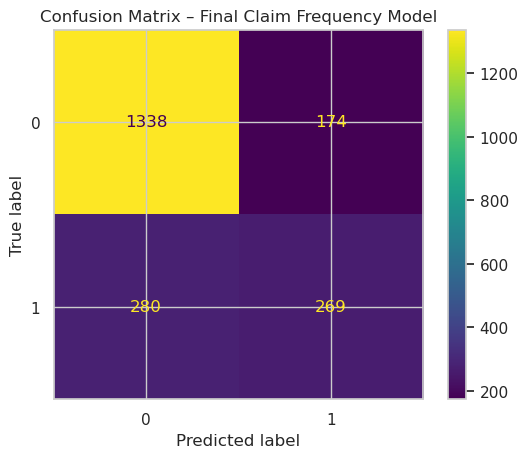

Final ROC-AUC (RandomForest, reduced features): 0.809


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


<Figure size 500x400 with 0 Axes>

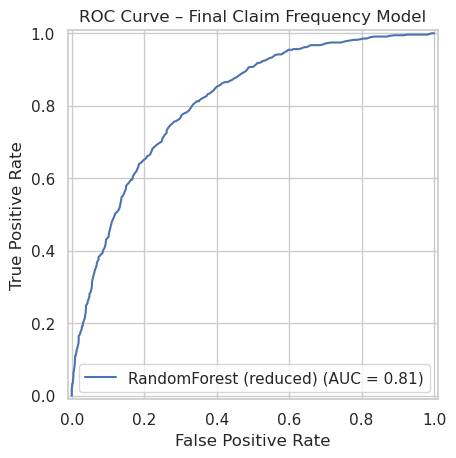

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report, roc_curve

print("=== Final Classifier (RandomForest with SHAP-based feature reduction) ===")
print("\nClassification report:")
print(classification_report(y_test_cls, y_pred_reduced))

# Confusion matrix for final classifier
cm_reduced = confusion_matrix(y_test_cls, y_pred_reduced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reduced, display_labels=[0, 1])

plt.figure(figsize=(4, 4))
disp.plot(values_format="d")
plt.title("Confusion Matrix – Final Claim Frequency Model")
plt.show()

# ROC curve for final classifier
fpr, tpr, _ = roc_curve(y_test_cls, y_proba_reduced)
roc_auc_final = roc_auc_score(y_test_cls, y_proba_reduced)
print(f"Final ROC-AUC (RandomForest, reduced features): {roc_auc_final:.3f}")

plt.figure(figsize=(5, 4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_final,
                estimator_name="RandomForest (reduced)").plot()
plt.title("ROC Curve – Final Claim Frequency Model")
plt.show()


### Cell 15: Final Claim Frequency Model Evaluation

In this cell, we evaluate the final Random Forest classifier after SHAP-based feature reduction. The confusion matrix shows that most no-claim cases are correctly classified, while a reasonable number of actual claim cases are also detected.

The final model achieves an accuracy of about 0.78, with a precision of about 0.61 and recall of about 0.49 for the claim class. This means the model correctly identifies nearly half of all actual claims while keeping false alarms at a moderate level.

The ROC curve shows good separation between claim and no-claim cases, and the final ROC-AUC is about 0.81. This confirms that the simplified model retains strong predictive power after feature reduction.


In [35]:
print("=== Threshold experiment (Final classifier) ===")
print("Effect of different probability thresholds on precision/recall for CLAIM (class 1):\n")

thresholds_to_test = [0.3, 0.5, 0.7]

for thr in thresholds_to_test:
    y_pred_thr = (y_proba_reduced >= thr).astype(int)
    prec_thr = precision_score(y_test_cls, y_pred_thr, zero_division=0)
    rec_thr = recall_score(y_test_cls, y_pred_thr, zero_division=0)
    print(f"Threshold {thr:.2f} -> Precision: {prec_thr:.3f}, Recall: {rec_thr:.3f}")


=== Threshold experiment (Final classifier) ===
Effect of different probability thresholds on precision/recall for CLAIM (class 1):

Threshold 0.30 -> Precision: 0.456, Recall: 0.812
Threshold 0.50 -> Precision: 0.605, Recall: 0.494
Threshold 0.70 -> Precision: 0.752, Recall: 0.166


### Cell 16: Threshold Experiment for Final Classifier

This cell shows how changing the probability threshold affects precision and recall for claim prediction.

At a threshold of 0.30, the model achieves very high recall of about 0.81, meaning it detects most actual claims, but precision drops to about 0.46, leading to many false alarms. At the default threshold of 0.50, precision and recall are more balanced at about 0.61 and 0.49. At a high threshold of 0.70, precision increases to about 0.75, but recall falls sharply to about 0.17, meaning most claims are missed.

This demonstrates the business trade-off between catching more risky customers versus avoiding false alarms.


In [36]:
# Build X/y for severity (regression) using ONLY positive claims

train_pos = train_df[train_df[TARGET_CLS] == 1].reset_index(drop=True)
test_pos = test_df[test_df[TARGET_CLS] == 1].reset_index(drop=True)

X_train_reg = train_pos[numeric_features + categorical_features]
y_train_reg = train_pos[TARGET_REG]

X_test_reg = test_pos[numeric_features + categorical_features]
y_test_reg = test_pos[TARGET_REG]

X_train_reg_pre = preprocessor.transform(X_train_reg)
X_test_reg_pre = preprocessor.transform(X_test_reg)

print("Severity shapes:", X_train_reg_pre.shape, X_test_reg_pre.shape)


Severity shapes: (2197, 45) (549, 45)


### Cell 17: Preparing Data for Claim Severity Modeling

In this cell, we prepare the dataset for claim severity prediction by selecting only the records where a claim actually occurred. This ensures that the regression model learns only from positive claim cases.

After preprocessing, the training set contains 2,197 claim records and the test set contains 549 claim records. Both are transformed into 45 numerical features using the same preprocessing pipeline as the classification model.


MAE: 1525.6918638433513
RMSE: 1786.1289357095206
R^2: -0.021110416883147076
Mean actual claim amount: 4104.17


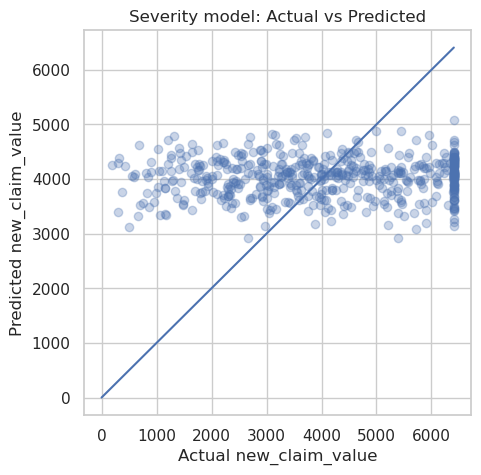

In [37]:
# Train severity model (RandomForestRegressor)

reg = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

reg.fit(X_train_reg_pre, y_train_reg)

y_pred_reg = reg.predict(X_test_reg_pre)

print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
rmse = mean_squared_error(y_test_reg, y_pred_reg) ** 0.5
print("RMSE:", rmse)

print("R^2:", r2_score(y_test_reg, y_pred_reg))
print(f"Mean actual claim amount: {y_test_reg.mean():.2f}")

plt.figure(figsize=(5,5))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.xlabel("Actual new_claim_value")
plt.ylabel("Predicted new_claim_value")
plt.title("Severity model: Actual vs Predicted")
plt.plot([0, y_test_reg.max()], [0, y_test_reg.max()])
plt.show()



### Cell 18: Severity Model Performance

In this cell, we evaluate the Random Forest regression model used to predict claim severity for customers who filed a claim. The model achieves a mean absolute error of about 1,526 and an RMSE of about 1,786.

The R² value is slightly negative, which indicates that the model struggles to explain the variance in claim amounts and performs close to a baseline prediction. The average actual claim amount is about 4,104, which shows that the prediction error is relatively large compared to the typical claim size.

The scatter plot shows that the model predictions are concentrated in a narrow range, meaning the model has difficulty capturing very high and very low claim values accurately.


### SHAP Analysis – Claim Severity Model (How costly will the claim be?)

Using 549 samples out of 549 for severity SHAP.
shap_vals_reg shape: (549, 45)
X_test_reg_sample shape: (549, 45)


/tmp/ipykernel_8142/3057334542.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


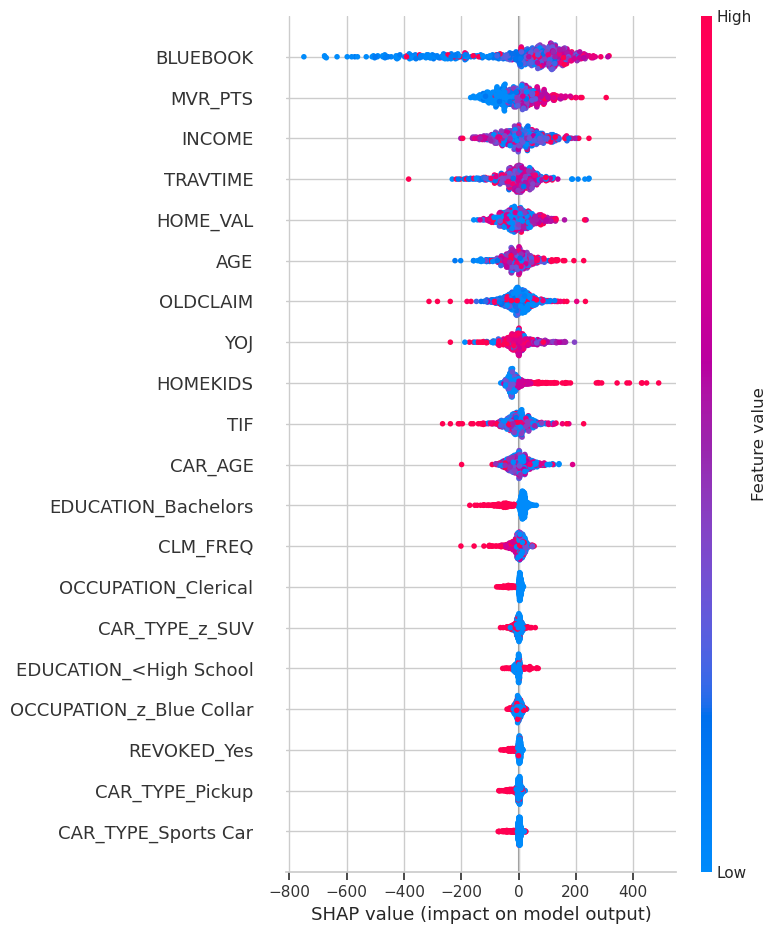

In [22]:
# SHAP for severity model

n_test_reg = X_test_reg_pre.shape[0]
max_samples_reg = 800
sample_size_reg = min(max_samples_reg, n_test_reg)

rng = np.random.default_rng(RANDOM_STATE)
idx_reg = rng.choice(n_test_reg, size=sample_size_reg, replace=False)
X_test_reg_sample = X_test_reg_pre[idx_reg]

print(f"Using {sample_size_reg} samples out of {n_test_reg} for severity SHAP.")

explainer_reg = shap.TreeExplainer(reg)
shap_values_raw_reg = explainer_reg.shap_values(
    X_test_reg_sample,
    check_additivity=False
)

# For a single-output regressor, this should already be (n_samples, n_features)
if isinstance(shap_values_raw_reg, list):
    shap_vals_reg = shap_values_raw_reg[0]
else:
    shap_vals_reg = shap_values_raw_reg

print("shap_vals_reg shape:", shap_vals_reg.shape)
print("X_test_reg_sample shape:", X_test_reg_sample.shape)

shap.summary_plot(
    shap_vals_reg,
    X_test_reg_sample,
    feature_names=all_feature_names
)

### Cell 19: SHAP Results for Claim Severity Model

This cell explains which features influence the predicted claim amount. The SHAP summary plot shows that vehicle value (BLUEBOOK), driving risk (MVR_PTS), income, travel time, and home value are the strongest drivers of claim severity.

Higher vehicle value and higher driving risk generally lead to higher predicted claim costs. Income and property value also increase predicted severity, which aligns with real-world insurance behavior where wealthier customers and expensive vehicles tend to result in larger claims.

This SHAP analysis makes the severity model interpretable by clearly showing why certain claims are predicted to be more expensive than others.


In [38]:
# Conditional pipeline – classification → severity

def predict_claim_and_cost(raw_df: pd.DataFrame, prob_threshold: float = 0.5):
    """
    raw_df: new data with original dataset columns
    Returns DataFrame with predicted is_claim and expected claim cost.
    """
    # Basic cleaning mirroring our earlier steps
    df = raw_df.copy()

    for col in money_cols:
        if col in df.columns and df[col].dtype == "O":
            df[col] = (
                df[col]
                .replace("[^0-9.]", "", regex=True)
                .replace("", np.nan)
                .astype(float)
            )
    if "CAR_AGE" in df.columns:
        car_age = df["CAR_AGE"]
        median_age = car_age[(car_age >= 0) & (car_age <= 30)].median()
        df["CAR_AGE"] = car_age.clip(lower=0, upper=30).fillna(median_age)

    # Feature subset
    X_raw = df[numeric_features + categorical_features]
    X_pre = preprocessor.transform(X_raw)

    # Apply same feature reduction as classification
    X_pre_red = X_pre[:, keep_mask]

    # Predict probability of a claim
    proba = clf_reduced.predict_proba(X_pre_red)[:, 1]
    is_claim_pred = (proba >= prob_threshold).astype(int)

    # For rows predicted as claim, run severity model; else cost = 0
    cost_pred = np.zeros(len(df))
    idx_claim = np.where(is_claim_pred == 1)[0]
    if len(idx_claim) > 0:
        cost_pred[idx_claim] = reg.predict(X_pre[idx_claim])

    result = df.copy()
    result["pred_is_claim"] = is_claim_pred
    result["pred_claim_probability"] = proba
    result["pred_claim_cost"] = cost_pred

    return result

# Example usage on test set
demo_results = predict_claim_and_cost(test_df)
demo_results[["pred_is_claim", "pred_claim_probability", "pred_claim_cost"]].head()


,pred_is_claim,pred_claim_probability,pred_claim_cost
0,1,0.610000,3697.8765
1,0,0.320000,0.0000
2,1,0.526667,4432.4450
3,0,0.196667,0.0000
4,1,0.596667,3954.6750


### Cell 20: Conditional Pipeline Output

This output shows the final combined predictions from the classification and severity models. For each customer, the model first predicts whether a claim will occur along with the claim probability.

For customers predicted as claim cases, the severity model estimates the expected claim cost. For customers predicted as no-claim cases, the predicted claim cost is correctly set to zero.

This confirms that the conditional pipeline is working as intended by linking claim occurrence prediction with financial impact estimation.


In [40]:
# Save preprocessor & models to local disk and upload to S3

import joblib

os.makedirs("artifacts", exist_ok=True)

joblib.dump(preprocessor, "artifacts/preprocessor.joblib")
joblib.dump(clf_reduced, "artifacts/claim_classifier.joblib")
joblib.dump(reg, "artifacts/severity_regressor.joblib")
joblib.dump(keep_mask, "artifacts/cls_keep_mask.npy")

print("Saved artifacts locally")

s3 = boto3.client("s3", region_name=CONFIG["AWS_REGION"])

for fname in os.listdir("artifacts"):
    local_path = os.path.join("artifacts", fname)
    key = "artifacts/" + fname
    s3.upload_file(local_path, CONFIG["S3_BUCKET"], key)
    print(f"Uploaded {local_path} → s3://{CONFIG['S3_BUCKET']}/{key}")


Saved artifacts locally
Uploaded artifacts/severity_regressor.joblib → s3://mlc-group7-project/artifacts/severity_regressor.joblib
Uploaded artifacts/cls_keep_mask.npy → s3://mlc-group7-project/artifacts/cls_keep_mask.npy
Uploaded artifacts/preprocessor.joblib → s3://mlc-group7-project/artifacts/preprocessor.joblib
Uploaded artifacts/claim_classifier.joblib → s3://mlc-group7-project/artifacts/claim_classifier.joblib


### Cell 21: Successful Model Artifact Upload to S3

In this cell, all trained machine learning components are successfully saved locally and uploaded to the S3 bucket. This includes the claim classifier, severity regressor, preprocessing pipeline, and the feature selection mask.

This confirms that the complete modeling pipeline is now stored safely in the cloud and is ready for deployment or future inference use.
